# Natural Language Processing Project

Welcome to the NLP Project for this section of the course. In this NLP project you will be attempting to <ins>_classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews_</ins>. 

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013). Each observation in this dataset is a review of a particular business by a particular user.
- `stars`: is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) 
    + In other words, it is the rating of the business by the person who wrote the review.
- `cool`: the number of "cool" votes this review received from other Yelp users. 
    + All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. 
    + In other words, it is a rating of the review itself, not a rating of the business.
- `useful` and `funny`: are similar to the "cool" column.

Let's get started...

### Imports
**1.**  
Import packages needed

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

### The Data

**2.**  
Read the `yelp.csv` file and set it as a dataframe called `yelp`.

In [2]:
yelp_df = pd.read_csv('Datasets/yelp.csv')
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


**3.**  
Check the `info` and `describe` methods on yelp df

In [4]:
# 10 columns each with 10_000 entries
# [`stars`,`cool`,`useful`,`funny`] are int; rest are objects
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp_df.describe() # <--- only describes the int objects

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**4.**  
Create a new column called `text length` which is the number of words in the text column.

In [9]:
yelp_df['text_length'] = yelp_df.text.apply(len)
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


# I. _EDA_

Let's explore the data

**5.**  
Use `FacetGrid` from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings. 

/Users/user/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


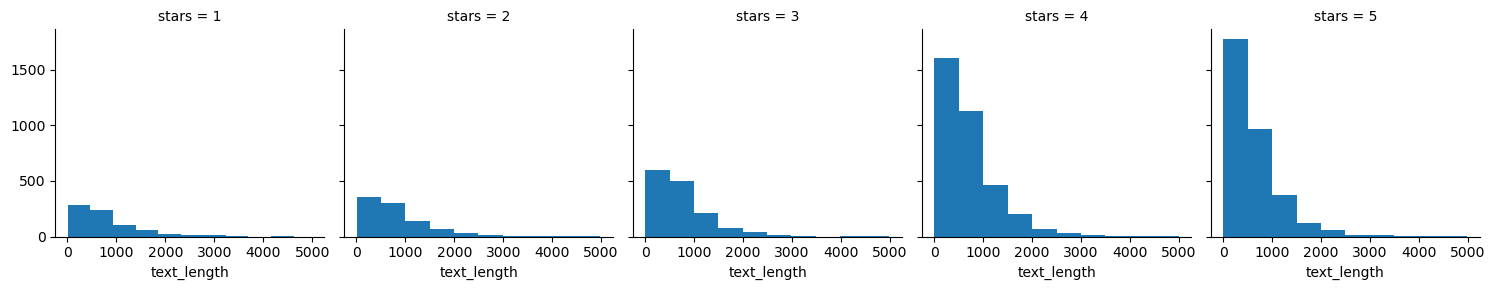

In [14]:
sns.FacetGrid(yelp_df, col='stars').map(plt.hist,'text_length')

**6.**  
Create a boxplot of text length for each star category

<Axes: xlabel='stars', ylabel='text_length'>

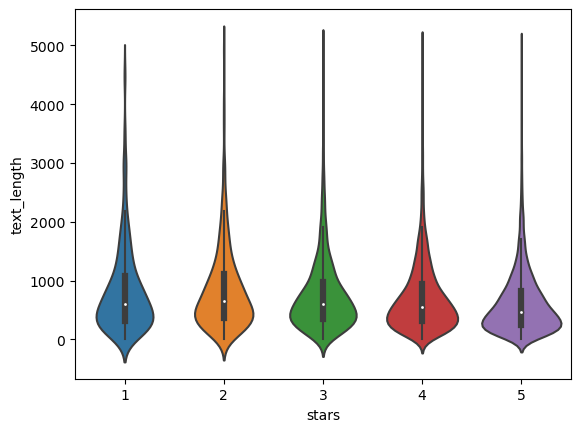

In [35]:
# i decided to do a violin plot
sns.violinplot(data=yelp_df, y='text_length', x='stars') 

**7.**  
Create a `countplot` of the number of occurrences for each type of star rating.

stars
4    3526
5    3337
3    1461
2     927
1     749
Name: count, dtype: int64


<Axes: xlabel='stars', ylabel='count'>

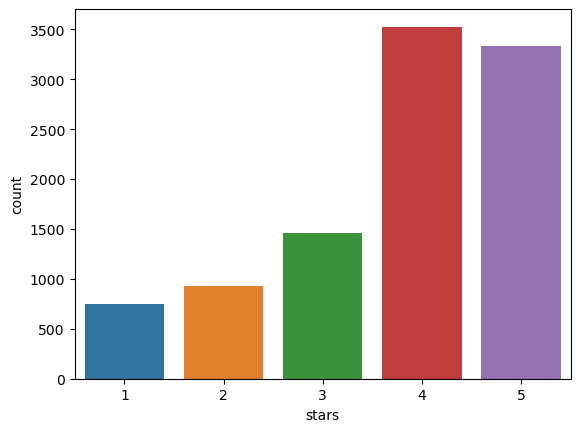

In [36]:
print(yelp_df.stars.value_counts())

sns.countplot(yelp_df, x='stars')

**8.**  
Use `groupby` to get the _mean values_ of the numerical columns. Create a dataframe with the operation.

In [37]:
stars_df = yelp_df[['cool', 'useful', 'funny', 'text_length', 'stars']].groupby('stars').mean()
stars_df

,cool,useful,funny,text_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**9.**  
Use the `corr()` method on that groupby dataframe a correlation maxtrix:

In [38]:
stars_df.corr()

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


**10.**  
Use seaborn to create a heatmap based off that `.corr()` dataframe

<Axes: >

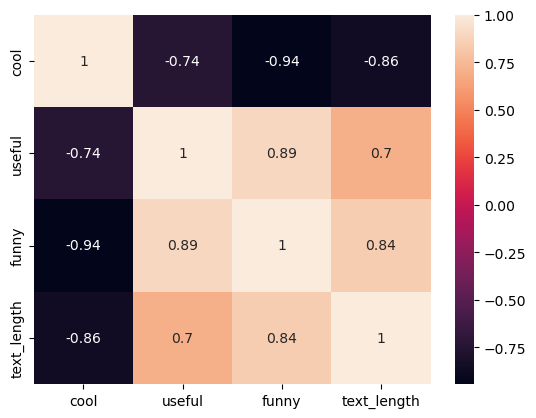

In [40]:
sns.heatmap(stars_df.corr(), annot=True)

# II. NLP Classification Task

Let's move on to the actual task. To make things a little easier, go ahead and only grab reviews that were either 1 star or 5 stars.

**11.**  
Create a dataframe called `yelp_class` that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.

In [52]:
yelp_class = yelp_df[(yelp_df.stars==1) | (yelp_df.stars==5)]
yelp_class.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


**12.**  
Create two objects `X` and `y`. `X` will be the `text` column of `yelp_class` and `y` will be the `stars` column of `yelp_class` (thewse are the features and target/labels)**

In [60]:
X = yelp_class.text
y = yelp_class.stars

**13.**  
Import `CountVectorizer` (_done_) and create a CountVectorizer object (Remember, this will help convert a collection of text documents to a matrix of token counts).

In [56]:
cv = CountVectorizer()

**14.**  
Use the `fit_transform` method on the CountVectorizer object and pass in `X` (the `text` column). Save this result by overwriting X.

In [61]:
X = cv.fit_transform(X)

## i. Train Test Split

Let's split our data into training and testing data.

**15.**  
Use `train_test_split` to split up the data into X_train, X_test, y_train, y_test. Use `test_size=0.3` and `random_state=101`

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## ii. Training a Model

Time to train a model!

**16.**  
Import `MultinomialNB` (_done_) 
- Create an instance of the estimator and call is `nb`.
- Now fit `nb` using the training data.

In [66]:
nb = MultinomialNB().fit(X_train, y_train)

## iii. Predictions and Evaluations

Time to see how our model did!

**17.**  
Use the predict method off of `nb` to predict labels from `X_test`.

In [68]:
nb_predict = nb.predict(X_test)

**18.**  
Create a confusion matrix and classification report using these predictions and `y_test`.

In [72]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,nb_predict))
print("")
print("Classification Matrix:")
print(classification_report(y_test,nb_predict))

Confusion Matrix:
[[159  69]
 [ 22 976]]

Classification Matrix:
              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



# III. Using Text Processing

Let's see what happens if we try to include TF-IDF to this process using a pipeline.

**19.**
Now create a pipeline with the following steps:
- CountVectorizer() 
- TfidfTransformer()
- MultinomialNB()

In [76]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

**Time to use the pipeline!**  
<ins>_Remember_</ins>:  
This pipeline has all your pre-process steps in it already, meaning we'll need to re-split the original data (Remember that we overwrote X as the CountVectorized version. What we need is just the text

## i. Train Test Split

**20.**  
Redo the train test split on the `yelp_class` object.

In [77]:
X = yelp_class.text
y = yelp_class.stars

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**21.**  
Now fit the pipeline to the training data (_Reminder_: you can't use the same training data as last time because that data has already been vectorized. We need to pass in just the text and labels)

In [78]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

## ii. Predictions and Evaluation

**22.**  
Now use the pipeline to predict from the `X_test` and create a classification report and confusion matrix. You should notice strange results.

In [79]:
pipe_predict = pipeline.predict(X_test)

In [80]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,pipe_predict))
print("")
print("Classification Matrix:")
print(classification_report(y_test,pipe_predict))

Confusion Matrix:
[[  0 228]
 [  0 998]]

Classification Matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looks like Tf-Idf actually made things worse! 

___
### _Bonus_

Other things to try an dimprove the results:  
- Does creating a custom analyzer like we did in the lecture helps (note: it probably won't). 
    + Maybe fixing the error present will help slightly.
- Recreate the pipeline with just the `CountVectorizer()` and `NaiveBayes`. 
    + Does changing the ML model at the end to another classifier help at all?